# Convolutional Neural Networks¶

Nick Chao

#### Dataset Selection

Select a dataset identically to the way you selected for the lab one (i.e., table data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is it cannot be a binary classification; it must be multi-class prediction. 

### Preparation (30 points total)  

[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (60 points total)
[15 points] Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

[20 points] Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

[15 points] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

[10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### Exceptional Work (10 points total)

You have free reign to provide additional analyses. 
One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance. 

### Business Understanding

In this lab we will be dealing with image data. I've decided to use Cidar-10 small images as there are about 60,000 (32x32) images with the following labels:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

The goal with this lab is to create a model that can predict as well as possible according to the F1 Score. A succcessful model would have great applications with future technology as it can perform image recongnition with multiple classes. If it is possible to deploy a model that has a strong F1 score then it could be used for people large, expensive computationally expensive computers. 

For this to be an effective application, I would ideally want an F1 score of around 90% so that the majority of images can be classified correctly without the need for a human to intervene that much. However, this may not be possible so my goal would be around 70-75% but with high catagorical accuracy and without having to train the model for days. 

### Dependencies

In [1]:
import os
import keras
import numpy as np
import seaborn as sns
import _pickle as pickle
import scipy
import pandas as pd

from matplotlib import pyplot as plt

from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import interp

#skimage.transform.resize

from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
#from skimage.io import imshow
#from skimage.feature import daisy
#from skimage.transform import resize
#from skimage import data, color


%matplotlib inline

/usr/local/es7/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preparation

In [2]:
# From https://keras.io/datasets/
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
NUM_CLASSES = 10
Y_train_ohe = keras.utils.to_categorical(Y_train, NUM_CLASSES)
Y_test_ohe = keras.utils.to_categorical(Y_test, NUM_CLASSES)

In [4]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

### Metrics

Before we begain, we need to decide on a metric to measure the success of our model. When classifying an image, there are four possible cases that could occur. 

1) True Positive: The image is class X and it was classified as class X

2) True Negative: The image is not class X and is not classified as X

3) False Positive: The image is not class X and is classified as X

4) False Negative: The image is class X and is not classified as X

It should be noted that the TP and TN are complimentary and paired up with each other in these cases. 

More information about these cases can be found here https://www.researchgate.net/post/How_to_define_Ture_Positive_TP_True_NegativeTN_False_PositiveFP_False_NegativeFN

For this lab, I have decided to use a combination of multiple metrics to get the best feel about the success of this model. I will use categorical accuracy for interpreting the confusion matrices. As for the models, F-Score makes the most sense. This is because F-score (or F1 Score) is a combination of recall and precision. A good recall would be the ability for the model to identify all X class images as X. A high precision is the ability for the model to be correct when it claims image X is of class X. Since F1 Score is not part of the keras metric library, we must create a custom macro F1 score to test our model. 


### Cross-Validation

Now that we know how we are going to score and measure the success of our model, we need to decide how to split up the data. There are many different ways we can split the data up for training and testing purposes. In this specific senerio, we have a few properties of the dataset that should be considered. First of all, the dataset is perfectly balanced. All the images are the same size, there are exactly 6000 images per class, and there are 10 classes. In addition, there is no need for ordering data because this dataset is not a time-series or any sort of ordered series. Because of these characteristics, I believe it would be acceptable to use any number of different cross-validation methods. In the interest of time, I will be perform 2 splits of the shuffle split to train the model and visual the test data.




In [5]:
# from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras# from h 

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# pretty confusion matrices
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    f1 = mt.f1_score(y_test,yhat, average="macro")
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'F1: {:.4f}'.format(f1)+' Acc: {:.4f}'.format(acc))


In [7]:
X_train_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in X_train]
X_train_up = np.stack(X_train_up,axis=0)
print(X_train_up.shape)

X_test_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in X_test]
X_test_up = np.stack(X_test_up,axis=0)
print(X_test_up.shape)

NameError: name 'imresize' is not defined

### Lenet

In [9]:
%%time

l2_lambda = 0.0001
# build model
lenet = Sequential()
lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (32,32,3), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))
lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy', f1])

# the flow method yields batches of images indefinitely, with the given transformations
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(X_train, Y_train_ohe):
    lenet.fit_generator(datagen.flow(X_train[train_index], Y_train_ohe[train_index], batch_size=128), 
      steps_per_epoch=int(len(X_train[train_index])/128), # how many generators to go through per epoch
      epochs=25, verbose=2,
      validation_data=(X_train[test_index],Y_train_ohe[test_index]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
     )

Epoch 1/25
 - 32s - loss: 1.7940 - acc: 0.3638 - f1: 0.1600 - val_loss: 1.8596 - val_acc: 0.3736 - val_f1: 0.2806
Epoch 2/25
 - 32s - loss: 1.5287 - acc: 0.4662 - f1: 0.3272 - val_loss: 1.5793 - val_acc: 0.4481 - val_f1: 0.3686
Epoch 3/25
 - 32s - loss: 1.4316 - acc: 0.5032 - f1: 0.3909 - val_loss: 1.4515 - val_acc: 0.4810 - val_f1: 0.4042
Epoch 4/25
 - 32s - loss: 1.3714 - acc: 0.5236 - f1: 0.4277 - val_loss: 1.6486 - val_acc: 0.4324 - val_f1: 0.3657
Epoch 5/25
 - 32s - loss: 1.3213 - acc: 0.5389 - f1: 0.4574 - val_loss: 1.5375 - val_acc: 0.4704 - val_f1: 0.4460
Epoch 6/25
 - 32s - loss: 1.2896 - acc: 0.5507 - f1: 0.4765 - val_loss: 1.4616 - val_acc: 0.4885 - val_f1: 0.4513
Epoch 7/25
 - 32s - loss: 1.2662 - acc: 0.5612 - f1: 0.4925 - val_loss: 1.3682 - val_acc: 0.5166 - val_f1: 0.4493
Epoch 8/25
 - 32s - loss: 1.2428 - acc: 0.5672 - f1: 0.5038 - val_loss: 1.3329 - val_acc: 0.5372 - val_f1: 0.4886
Epoch 9/25
 - 32s - loss: 1.2257 - acc: 0.5761 - f1: 0.5131 - val_loss: 1.2705 - val_acc

temp

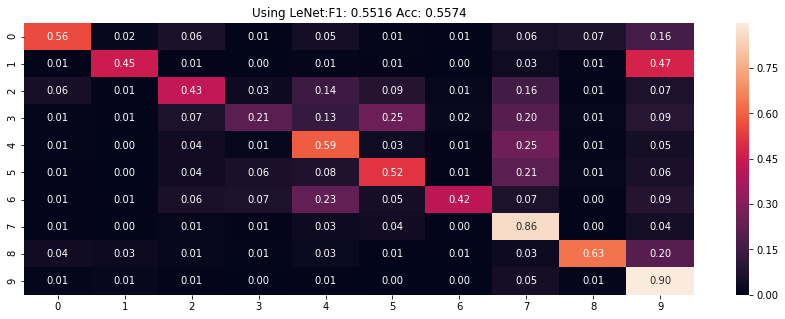

In [10]:
summarize_net(lenet, X_test, Y_test, title_text='Using LeNet:')

temp

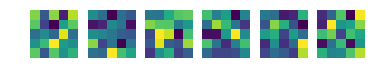

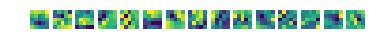

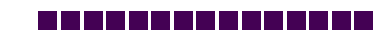

In [11]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()

### Simple CNN Model

temp

In [12]:
# Simple CNN model for CIFAR-10

K.set_image_dim_ordering('th')

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 16, 16)        36928     
__________

TEMP

In [13]:
seed = 7
np.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(X_train, y_train):
    model.fit(X_train[train_index], y_train[train_index], validation_data=(X_train[test_index], y_train[test_index]), epochs=epochs, batch_size=64)
    # Final evaluation of the model
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 117s 3ms/step - loss: 2.0167 - acc: 0.2499 - f1: 0.0487 - val_loss: 1.8194 - val_acc: 0.3385 - val_f1: 0.0889
Epoch 2/25
40000/40000 [==============================] - 116s 3ms/step - loss: 1.6048 - acc: 0.4133 - f1: 0.2496 - val_loss: 1.4804 - val_acc: 0.4671 - val_f1: 0.2924
Epoch 3/25
40000/40000 [==============================] - 115s 3ms/step - loss: 1.4179 - acc: 0.4860 - f1: 0.3811 - val_loss: 1.3263 - val_acc: 0.5159 - val_f1: 0.4087
Epoch 4/25
40000/40000 [==============================] - 114s 3ms/step - loss: 1.2904 - acc: 0.5319 - f1: 0.4575 - val_loss: 1.3313 - val_acc: 0.5329 - val_f1: 0.4657
Epoch 5/25
40000/40000 [==============================] - 113s 3ms/step - loss: 1.1900 - acc: 0.5695 - f1: 0.5154 - val_loss: 1.1360 - val_acc: 0.5853 - val_f1: 0.5264
Epoch 6/25
40000/40000 [==============================] - 113s 3ms/step - loss: 1.1122 - acc: 0.5985 - f1: 0.5

Epoch 23/25
40000/40000 [==============================] - 112s 3ms/step - loss: 0.2664 - acc: 0.9039 - f1: 0.9038 - val_loss: 0.3978 - val_acc: 0.8667 - val_f1: 0.8679
Epoch 24/25
40000/40000 [==============================] - 112s 3ms/step - loss: 0.2584 - acc: 0.9066 - f1: 0.9070 - val_loss: 0.3766 - val_acc: 0.8730 - val_f1: 0.8743
Epoch 25/25
40000/40000 [==============================] - 112s 3ms/step - loss: 0.2586 - acc: 0.9072 - f1: 0.9074 - val_loss: 0.3891 - val_acc: 0.8689 - val_f1: 0.8705
Accuracy: 86.89%


TEMP

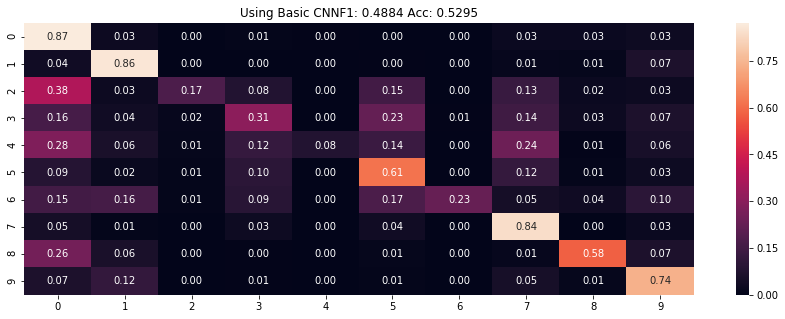

In [14]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

summarize_net(model, X_test, y_test, title_text='Using Basic CNN')

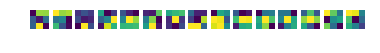

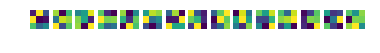

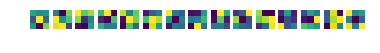

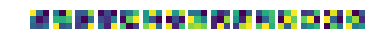

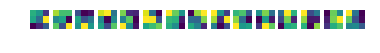

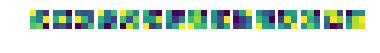

In [15]:
max_plots = 15
for layer in model.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()

## MLP

TEMP

In [16]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./data/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('../data/cifar-10-batches-py'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(pickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('../data/cifar-10-batches-py/batches.meta', 'rb') as fo:
        labels_tmp = pickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


In [45]:
daisies = np.array([np.concatenate(
    np.concatenate(daisy(
        x.reshape((32,32)), 
        step=16, 
        radius=7, 
        rings=2, 
        histograms=8, 
        orientations=5))) for x in img_gray])

NameError: name 'daisy' is not defined

In [46]:
# SKLearn's implementation
x = daisies
y = img_labels
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat_mlp = pl.predict(x[test_index])
    print('f1 score:', mt.f1_score(y[test_index], yhat_mlp, average='macro'))
    print(np.bincount(yhat_mlp))

NameError: name 'daisies' is not defined

In [47]:
plt.figure(figsize=(15,5))
cm = mt.confusion_matrix(y[test_index],yhat_mlp)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
acc = mt.accuracy_score(y[test_index],yhat_mlp)
f1 = mt.f1_score(y[test_index],yhat_mlp, average="macro")
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title("Using MLP:"+'f1: {:.4f}'.format(f1)+' acc: {:.4f}'.format(acc))

NameError: name 'y' is not defined

<Figure size 1080x360 with 0 Axes>